In [117]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from iminuit import Minuit
from scipy.interpolate import interp1d

%matplotlib widget

# Step 1: Fraction of absorbed photons


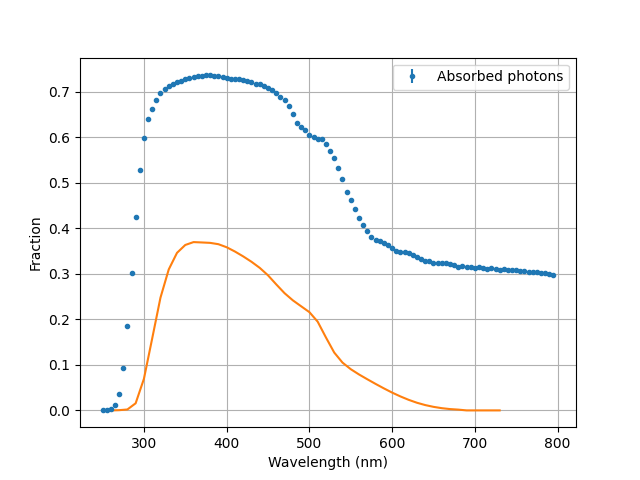

In [118]:
wvs, h,_ =np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/build/step1_new.dat", unpack=1)
x, QE = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/QE/DEGG_Hamamatsu_R5912_20_100_mean_QE.dat", unpack=1)
N=500000
err = np.sqrt(h) / N
h /= N
 
plt.figure()
plt.errorbar(wvs, h, fmt=".", yerr = err, label ="Absorbed photons")
plt.plot(x,QE)
plt.ylabel("Fraction")
plt.xlabel("Wavelength (nm)")
plt.grid()
plt.legend()
np.savetxt("DEGG_Hamamatsu_R5912_20_100_intrinsic_QE.dat", np.array([wvs, h, err]).T, delimiter="\t", header="Wavelength(nm) \t QE \t error")

# Step 2

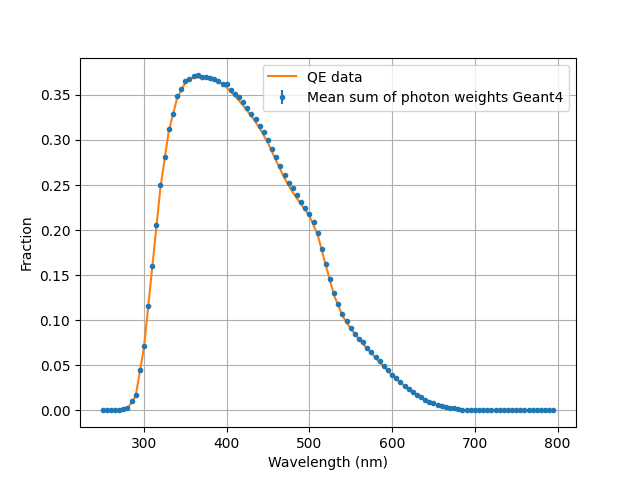

In [119]:
wvs, h,w =np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/build/step2_new.dat", unpack=1)
x, QE = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/QE/DEGG_Hamamatsu_R5912_20_100_mean_QE.dat", unpack=1)
N=100000
err = np.sqrt(h)*w/N**2
h /= N
w /= N
 
 
plt.figure()
plt.errorbar(wvs, w, fmt=".", yerr = err, label ="Mean sum of photon weights Geant4")

plt.legend()
plt.plot(x,QE, label = "QE data")
plt.ylabel("Fraction")
plt.xlabel("Wavelength (nm)")
plt.grid()
plt.legend()
#np.savetxt("DEGG_Hamamatsu_R5912_20_100_intrinsic_QE_800.dat", np.array([wvs, h, err]).T, delimiter="\t", header="Wavelength(nm) \t QE \t error")

# Step 3

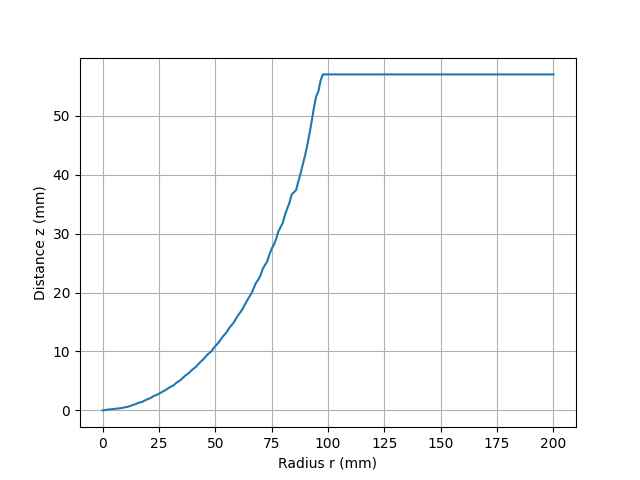

In [120]:
#Looking at the z correction

r,z = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/setup_stuff/DEGG_used_z_compensation.txt", usecols=(0,1), unpack=True)

# I had to adjust the z distance between 80 < r < 100 
plt.figure()
plt.plot(r,z)
plt.xlabel('Radius r (mm)')
plt.ylabel('Distance z (mm)')
plt.grid()

In [121]:
def find_nearest(array, value):
    """Find the nearest value in an array."""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def initialize_dicts(Rs, Rbins):
    """Initialize the dictionary structure."""
    dicts = {}
    for r in Rs:
        dicts[r] = {
            "hist": np.zeros(Rbins.size - 1),
            "hist_weighted": np.zeros(Rbins.size - 1),
            "counts": 0,
            "total": 0,
            "total_weighted": 0
        }
    return dicts

def process_data(data, dicts, Rs, N = 10000):
    """Process the input data and update the dictionaries."""
    for line in data:
        x, y = line[0], line[1]
        h = line[2:]
        sz = int(h.size / 2)
        Rfile = np.sqrt(x**2 + y**2)
        nearest_R = find_nearest(Rs, Rfile)
        
        dicts[nearest_R]["hist"] += h[:sz]
        dicts[nearest_R]["hist_weighted"] += h[sz:]
        dicts[nearest_R]["counts"] += 1
        dicts[nearest_R]["total"] += np.sum(h[:sz])
        dicts[nearest_R]["total_weighted"] += np.sum(h[sz:])
    
    return dicts, N

def normalize_histograms(dicts, N):
    """Normalize the histograms in the dictionaries."""
    for key in dicts:
        counts = dicts[key]["counts"] + 1e-9  # Avoid division by zero
        dicts[key]["norm_hist"] = dicts[key]["hist"] / counts / N
        dicts[key]["norm_hist_weighted"] = dicts[key]["hist_weighted"] / counts / N
        dicts[key]["norm_hist_err"] = np.sqrt(dicts[key]["total"]) / counts / N
        dicts[key]["norm_hist_err_weighted"] = dicts[key]["norm_hist_err"]*dicts[key]["norm_hist_weighted"]/dicts[key]["norm_hist"]
    return dicts

In [122]:
# Parameters
step = 0.35
Rs = np.arange(0, 105.25, step)  # Binning of R_A

Rbins = np.arange(0, 105.25, step)  # Binning of simulation output 
Rbins_x = 0.5 * (Rbins[:-1] + Rbins[1:])
print(len(Rs),len(Rbins))


# Initialize dictionaries
dicts = initialize_dicts(Rs, Rbins)

# Load and process data
data = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/build/step3.dat")



dicts, N = process_data(data, dicts, Rs)

# Normalize histograms
dicts = normalize_histograms(dicts, N)
dicts["R_beam_position"] = Rs
dicts["R_absorbed_position"] = Rbins_x



301 301


/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/3611166848.py:44: RuntimeWarning: invalid value encountered in divide
  dicts[key]["norm_hist_err_weighted"] = dicts[key]["norm_hist_err"]*dicts[key]["norm_hist_weighted"]/dicts[key]["norm_hist"]


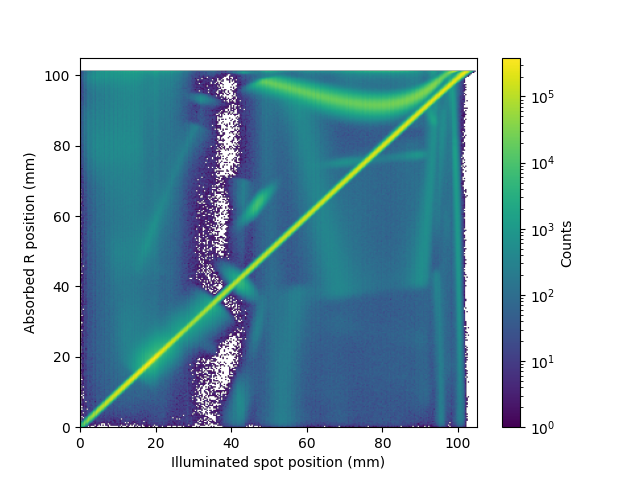

In [123]:
matrix = []
for r in Rs:
    matrix.append(dicts[r]["hist"])
matrix = np.array(matrix)

plt.figure()
im = plt.imshow(matrix.T, aspect="auto", origin="lower", norm=LogNorm(), extent= (Rs[0], Rs[-1], Rbins[0], Rbins[-1]))
plt.colorbar(im, label='Counts')
plt.xlabel("Illuminated spot position (mm)")
plt.ylabel("Absorbed R position (mm)")
plt.show()

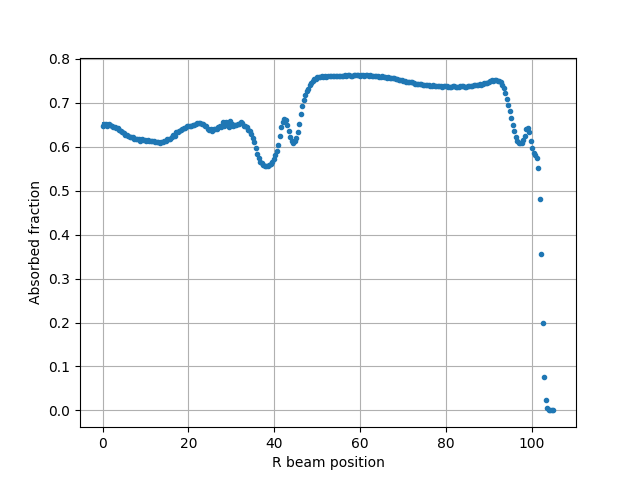

In [124]:
# Plot mean absorbed fraction of photons vs R
r_p = Rs
h_p = [dicts[r]["total"] / (dicts[r]["counts"] + 1e-9) / N for r in r_p]
e_p = [dicts[r]["norm_hist_err"] for r in r_p]

plt.figure()
plt.errorbar(r_p, h_p, yerr=e_p, fmt='.')
plt.grid(True)
#plt.xticks(np.arange(round(min(r_p)), round(max(r_p)), 5))
plt.xlabel("R beam position")
plt.ylabel("Absorbed fraction")
plt.show()

101.89854022506897


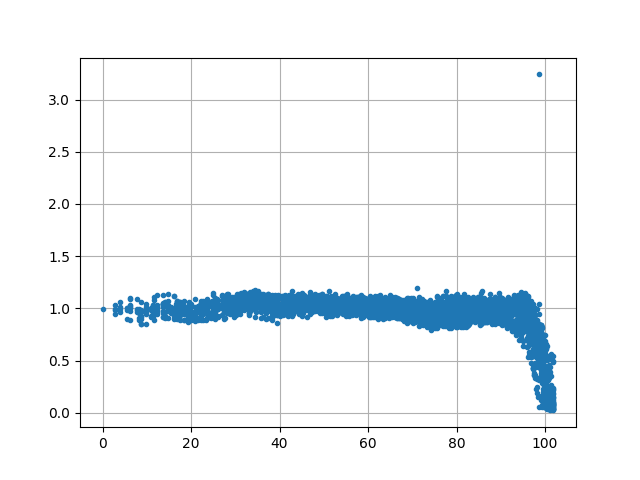

In [125]:
import pickle
with open("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/SQ0797-2dyndown-2_SPE_dict_scan_D-Egg","rb") as file:
    DEGG_dict=pickle.load(file)
with open("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/SQ0797-2dyndown-2_TT_dict_scan_D-Egg","rb") as file:
    DEGG_dict1=pickle.load(file)

DEGG_dict.update(DEGG_dict1)

x = DEGG_dict["R"]
print(max(x))
y = DEGG_dict["rDE"]
plt.figure()
plt.plot(x,y,".")
plt.grid()
plt.show()



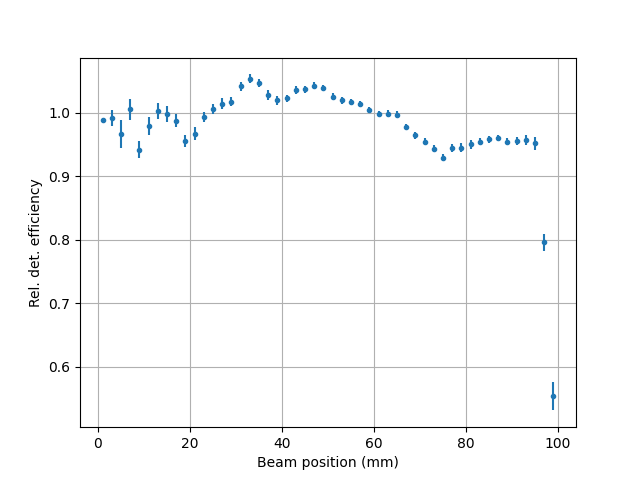

In [126]:
'''
The data was prepared from the measurement of 5 PMTs. 
The rel. detection efficiency scan was reduced to a profile, binning the scan by R. 
The binning started at R=1.5mm, since there are not enough data points at centre. The data at R<1.5 mm was averaged
and assigned to x=0.
x: is the central position of bin,(except for x=0)
y: average rel. det. efficiency 
y_err: std error between different pmts
step: Step of binning

y values were normalised with average detection efficiency in central region (R<25)
'''
def bin_data(x, y, bin_width):
    assert len(x) == len(y), f"Arrays x and y must be of the same length but they are not with len(x)={len(x)} and len(y)={len(y)}"
    x = np.array(x)
    y = np.array(y)
    new_x = np.arange(0, round(max(x)), bin_width)  # Define the bin positions
    new_y = []
    new_y_err = []

    for i in range(len(new_x)-1):
        prov_y = []
        # Get the indices of values within the bin range
        indices_in_bin = (x > new_x[i]) & (x <= new_x[i+1]) if i > 0 else (x <= new_x[i+1])
        # Filter the y values corresponding to the current bin
        prov_y = y[indices_in_bin]
        
        # Calculate the mean for the bin
        if len(prov_y) > 0 and prov_y.any():
            new_y.append(np.mean(prov_y))
            new_y_err.append(np.std(prov_y)/np.sqrt(len(prov_y)) if len(prov_y) > 1 else 0)
        else:
            #raise ValueError()
            new_y.append(np.nan)  # No data points in this bin
            new_y_err.append(np.nan)
    
    new_y = np.array(new_y)
    new_y_err = np.array(new_y_err)
    x2 = 0.5*(new_x[:-1]+new_x[1:])
    new_x = new_x[:-1]
    norm = np.mean(new_y[new_x<40])
    return x2, new_y/norm, new_y_err/norm  

new_x,new_y,err_y = bin_data(x,y,bin_width=2)

plt.figure()
plt.errorbar(new_x,new_y,yerr=err_y, fmt = ".")
plt.ylabel("Rel. det. efficiency")
plt.xlabel("Beam position (mm)")
plt.grid()


In [127]:
class Fit:
    def __init__(self, x, x_step, y, y_err, simu_data, r_weights):
        """
        Initialize the Fit class with data and simulation parameters.

        :param x: x-axis data points
        :param y: y-axis data points
        :param y_err: errors on y-axis data points
        :param simu_data: simulation data dictionary
        :param r_weights: r position of fitted weight values
        """
        self.x_data = x
        self.x_step = x_step
        self.y_data = y
        self.y_err_data = y_err
        self.simu_data = simu_data
        self.r_weights = r_weights
        self.y_err_sim = self.estimate_simulation_error()

    def estimate_simulation_error(self):
        """Estimate simulation error using interpolation."""
        e_p = [self.simu_data[r]["norm_hist_err"] for r in self.simu_data["R_beam_position"]]
        f = interp1d(self.simu_data["R_beam_position"], e_p, fill_value="extrapolate")
        return f(self.x_data)

    def trafo(self, fit_parameters):
        """
        Transform fitted parameters into CE weights.

        :param input_weights: fit parameters
        :return: Cumulative weights
        """
        weights = [1]  # at R=0 we assume CE = 1
        for diff in fit_parameters:
            new_weight = max(weights[-1] - diff, 0)
            weights.append(new_weight)
        return np.array(weights)

    def model(self, weights):
        weights = self.trafo(weights)  # Convert to cumulative weights
        f = interp1d(self.r_weights, weights, kind="slinear", fill_value=0, bounds_error=False)
        weights_detailed = f(self.simu_data["R_absorbed_position"])

        # Weight all histograms with CE weights
        weighted_histograms = [np.nansum(self.simu_data[r]["norm_hist"] * weights_detailed) 
                for r in self.simu_data["R_beam_position"]]
        weighted_histograms = np.array(weighted_histograms)

        # Calculate rel. DE values for each r position
        y = [self._calculate_y_value(weighted_histograms, i) for i in range(len(self.x_data))]
        y = np.array(y)

        # Normalize the output
        norm = np.mean(y[y > 0][self.x_data[y > 0] < 40])
        return y / norm

    def _calculate_y_value(self, weighted_histograms, index):
        #if index == 0:
        #    mask = self.simu_data["R_beam_position"] < self.x_data[1]-self.x_step*0.5
        #    return np.nanmean(weighted_histograms[mask])
        if True:
            mask = np.logical_and(self.simu_data["R_beam_position"] < self.x_data[index]+self.x_step*0.5,
                                  self.simu_data["R_beam_position"] >= self.x_data[index]-self.x_step*0.5)
            return np.nanmean(weighted_histograms[mask])

    def chi(self, *args):
        """
        Calculate chi-squared value for the model.

        :param args: Weight differences to be passed to the model
        :return: Chi-squared value
        """
        mdl = self.model(args)
        mask = np.logical_and(mdl > 0, self.x_data > 2)
        #print(mask,len(mask))
        #print(f"Length of mdl: {len(mdl)}")
        #print(f"Length of x_data: {len(self.x_data)}")
        #print(f"Length of y_data: {len(self.y_data)}")
        #print(f"Length of y_err_sim: {len(self.y_err_sim)}")
        #print(self.y_data[mask])
        return np.sum((self.y_data[mask] - mdl[mask]) ** 2 / self.y_err_sim[mask] ** 2)

In [128]:
fit_handling = Fit(new_x, 0.25, new_y, err_y, dicts, np.arange(0, 106, 1))

In [129]:
#First leave the central CE weights = 1
initial = {}
limits = {}
fix = {}
names = list()
p0 = []

for i,bins in enumerate(fit_handling.r_weights[:-1]):
    names.append("w_"+str(i))
    initial[names[-1]] = 0.0
    p0.append(0.0)
    if bins>7 and bins <30:
        limits[names[-1]] = (-0.15, 0.15)
        fix[names[-1]] = False
        #limits[names[-1]] =(-0.01, 0.01)
    elif bins<7:
        limits[names[-1]] = (-0.05, 0.05)
        fix[names[-1]] = True
        initial[names[-1]] = 1
    else:
        limits[names[-1]] = (-0.2, 0.2)
        fix[names[-1]] = False
        
    

In [130]:
m = Minuit(fit_handling.chi, *p0, name=names)

for key, val in limits.items():
    m.limits[key] = val
    
for key, val in fix.items():
    m.fixed[key] = val
    
m.strategy = 1
m.errordef = 1
fit_handling.chi(*p0) #Check that chi is working

/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/2805414882.py:64: RuntimeWarning: Mean of empty slice
  return np.nanmean(weighted_histograms[mask])


1721388.896873313

In [131]:
m.migrad(ncall = 500000)

/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/2805414882.py:64: RuntimeWarning: Mean of empty slice
  return np.nanmean(weighted_histograms[mask])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 344.6                      │             Nfcn = 36749             │
│ EDM = 0.000149 (Goal: 0.0002)    │           time = 56.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌────┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│    │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├────┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0  │ w_0   │    0.0    │    0.1    │            │            │  -0.05  │  0.05   │  yes  │
│ 1  │ w_1   │    0.0    │    0.1    │            │            │  -0.05  │  0.05   │  yes  │
│ 2  │ w_2   │    0.0    │    0.1    │            │            │  -0.05  │  0.05   │  yes  │
│ 3  │ w_3   │    0.0    │    0.1    │            │            │  -0.05  │  0.05   │  yes  │
│ 4  │ w_4   │    0.0    │    0.1    │            │            │  -0.05  │  0.05   │  yes  │
│ 5  │ w_5   │    0.0    │    0.1    │            │            │  -0.05  │  0.05   │  yes  │
│ 6  │ w_6   │    0.0    │    0.1    │            │            │  -0.05  │  0.05   │  yes  │
│ 7  │ w_7   │  -0.1330  │  0.0013   │            │            │  -0.2   │   0.2   │       │
│ 8  │ w_8   │ 150.00e-3 │  0.24e-3  │            │            │  -0.15  │  0.15   │       │
│ 9  │ w_9   │ 150.0e-3  │  0.9e-3   │            │            │  -0.15  │  0.15   │       │
│ 10 │ w_10  │  -0.079   │   0.005   │            │            │  -0.15  │  0.15   │       │
│ 11 │ w_11  │  -0.109   │   0.006   │            │            │  -0.15  │  0.15   │       │
│ 12 │ w_12  │  -0.036   │   0.012   │            │            │  -0.15  │  0.15   │       │
│ 13 │ w_13  │  0.0152   │  0.0014   │            │            │  -0.15  │  0.15   │       │
│ 14 │ w_14  │  0.0141   │  0.0023   │            │            │  -0.15  │  0.15   │       │
│ 15 │ w_15  │  26.3e-3  │  0.7e-3   │            │            │  -0.15  │  0.15   │       │
│ 16 │ w_16  │  29.9e-3  │  0.7e-3   │            │            │  -0.15  │  0.15   │       │
│ 17 │ w_17  │  28.1e-3  │  0.5e-3   │            │            │  -0.15  │  0.15   │       │
│ 18 │ w_18  │  20.1e-3  │  0.5e-3   │            │            │  -0.15  │  0.15   │       │
│ 19 │ w_19  │  -1.9e-3  │  0.8e-3   │            │            │  -0.15  │  0.15   │       │
│ 20 │ w_20  │  -6.7e-3  │  0.6e-3   │            │            │  -0.15  │  0.15   │       │
│ 21 │ w_21  │ -12.9e-3  │  0.8e-3   │            │            │  -0.15  │  0.15   │       │
│ 22 │ w_22  │ -13.9e-3  │  0.8e-3   │            │            │  -0.15  │  0.15   │       │
│ 23 │ w_23  │  -0.0075  │  0.0010   │            │            │  -0.15  │  0.15   │       │
│ 24 │ w_24  │  -8.2e-3  │  0.7e-3   │            │            │  -0.15  │  0.15   │       │
│ 25 │ w_25  │ -10.1e-3  │  0.7e-3   │            │            │  -0.15  │  0.15   │       │
│ 26 │ w_26  │   -6e-3   │   1e-3    │            │            │  -0.15  │  0.15   │       │
│ 27 │ w_27  │  0.0078   │  0.0012   │            │            │  -0.15  │  0.15   │       │
│ 28 │ w_28  │  0.0062   │  0.0010   │            │            │  -0.15  │  0.15   │       │
│ 29 │ w_29  │  -6.9e-3  │  0.6e-3   │            │            │  -0.15  │  0.15   │       │
│ 30 │ w_30  │ -10.

/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/2805414882.py:64: RuntimeWarning: Mean of empty slice
  return np.nanmean(weighted_histograms[mask])


Text(0, 0.5, 'Relative detection efficiency')

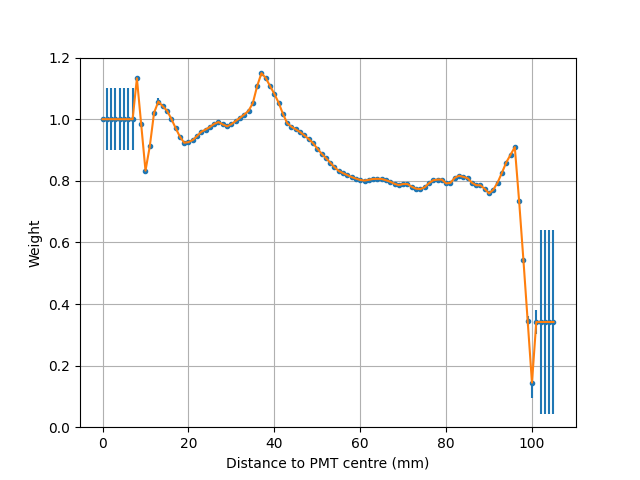

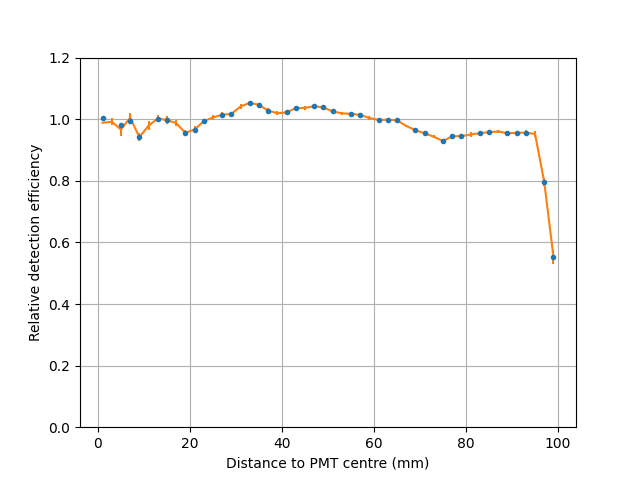

In [132]:
#Check current output
plt.figure()

plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values), yerr = np.append(0,m.errors), fmt =  '.')
plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values))
plt.grid()
plt.ylabel("Weight")
plt.xlabel("Distance to PMT centre (mm)")
plt.ylim(0,1.2)


plt.figure()
mdl = fit_handling.model(m.values)
plt.plot(fit_handling.x_data, mdl, zorder = 100, marker=".", ls="")
plt.errorbar(fit_handling.x_data,fit_handling.y_data, yerr=fit_handling.y_err_data, zorder = 10)
plt.ylim(0,1.2)
plt.grid()
plt.xlabel("Distance to PMT centre (mm)")
plt.ylabel("Relative detection efficiency")


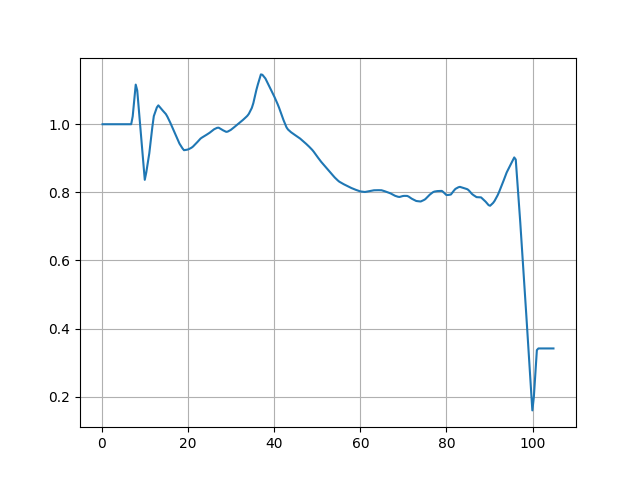

In [133]:
#Save weights
fl = interp1d(fit_handling.r_weights, fit_handling.trafo(m.values), kind = "slinear", fill_value=0, bounds_error=False) 
weights_detailed = fl(fit_handling.simu_data["R_absorbed_position"])
plt.figure()
plt.plot(fit_handling.simu_data["R_absorbed_position"], weights_detailed)
plt.grid()

#'''
with open("250123_DEGG.dat", "w") as f:
    f.write(f"#R(mm) Weight \n")
    f.write(f"{0}\t{fl(0)}\n")
    for r, weight in zip(fit_handling.simu_data["R_absorbed_position"], weights_detailed):
        f.write(f"{r}\t{weight}\n")
#'''

/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/3611166848.py:44: RuntimeWarning: invalid value encountered in divide
  dicts[key]["norm_hist_err_weighted"] = dicts[key]["norm_hist_err"]*dicts[key]["norm_hist_weighted"]/dicts[key]["norm_hist"]


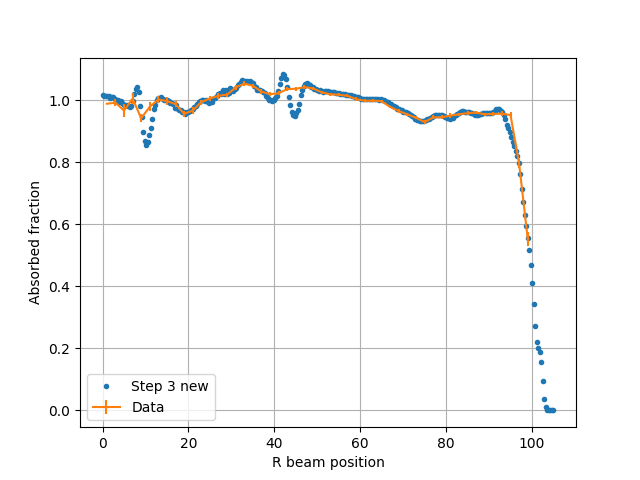

In [134]:

step = 0.35
Rs = np.arange(0, 105.25, step)  # Binning of R_A
Rbins = np.arange(0, 105.25, step)  # Binning of simulation output 
Rbins_x = 0.5 * (Rbins[:-1] + Rbins[1:])

# Initialize dictionaries
dicts = initialize_dicts(Rs, Rbins)

# Load and process data
data = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/build/step3_newnew.dat")
dicts, N = process_data(data, dicts, Rs, 1000)

# Normalize histograms
dicts = normalize_histograms(dicts, N)

# Plot mean absorbed fraction of photons vs R
r_p = Rs
h_p = np.array([dicts[r]["total_weighted"] / (dicts[r]["counts"] + 1e-9) / N for r in r_p])
e_p = [dicts[r]["norm_hist_err_weighted"] for r in r_p]

plt.figure()
plt.errorbar(r_p, h_p/np.mean(h_p[r_p<40]), ls="", marker=".", label = "Step 3 new")#, yerr = e_p, fmt='.')
plt.errorbar(fit_handling.x_data,fit_handling.y_data, yerr=fit_handling.y_err_data, zorder = 10, label = "Data")
plt.grid(True)
plt.legend()
#plt.xticks(np.arange(0, 45, 5))
plt.xlabel("R beam position")
plt.ylabel("Absorbed fraction")
plt.show()

# Step 4

In [135]:
r_beam, wavelength, r_mean, r_meadian, r_std, counts = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/build/step4_newnew.dat", unpack=1)

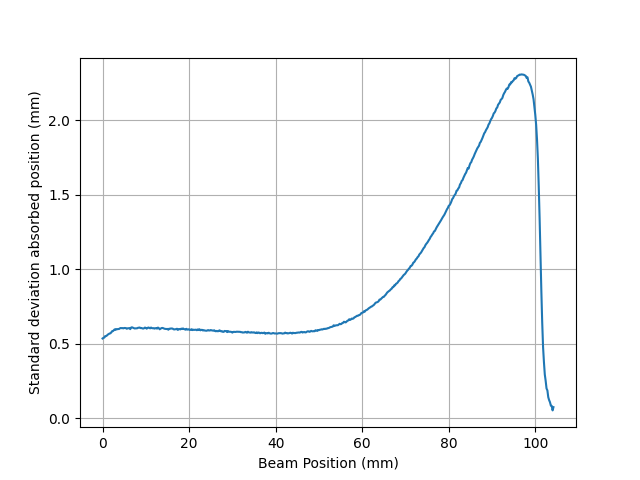

In [33]:
plt.figure()
plt.plot(r_beam[counts>10], r_std[counts>10])
plt.ylabel("Standard deviation absorbed position (mm)")
plt.xlabel("Beam Position (mm)")
plt.grid()

/Users/beritschlueter/Documents/Dokumente_MacBook/pythonenvs/py311/lib/python3.11/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/beritschlueter/Documents/Dokumente_MacBook/pythonenvs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/3491303459.py:10: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(r_beam[mask],r_mean[mask], 140)
/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/3491303459.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r_beam[mask],r_mean[mask]/r_beam[mask], '.')
/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/3491303459.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r_beam[mask], p(r_beam[mask])/r_b

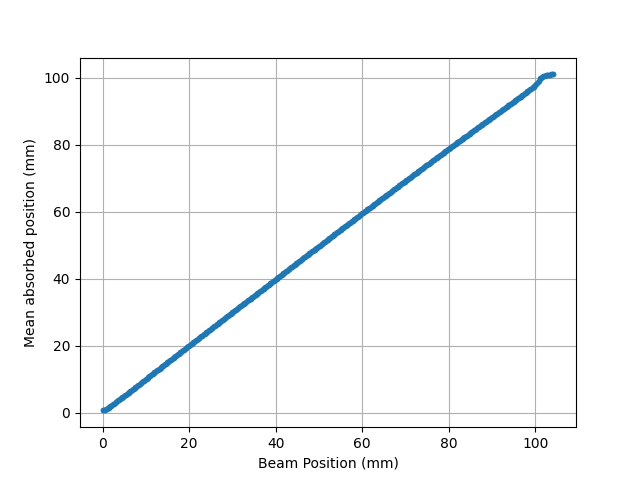

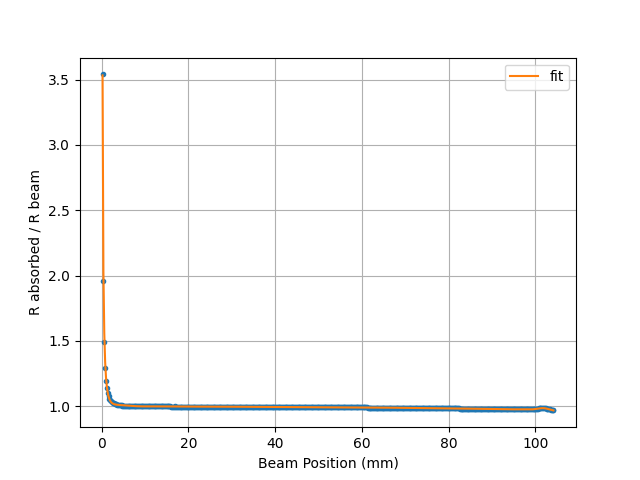

In [34]:
# We fit with polynomial the difraction
plt.figure()
plt.plot(r_beam[counts>0], r_mean[counts>0],'.')
plt.ylabel("Mean absorbed position (mm)")
plt.xlabel("Beam Position (mm)")
plt.grid()

rlim = 105
mask = np.logical_and(counts>0, r_beam<rlim)
z = np.polyfit(r_beam[mask],r_mean[mask], 140)
p = np.poly1d(z)

plt.figure()
plt.plot(r_beam[mask],r_mean[mask]/r_beam[mask], '.')
plt.plot(r_beam[mask], p(r_beam[mask])/r_beam[mask], label = "fit")
plt.legend()
plt.ylabel("R absorbed / R beam")
plt.xlabel("Beam Position (mm)")
plt.grid()

In [136]:
import pickle


with open("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/SQ0797-2dyndown-2_SPE_dict_scan_D-Egg","rb") as file:
    SPE_dict=pickle.load(file)
with open("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/SQ0797-2dyndown-2_TT_dict_scan_D-Egg","rb") as file:
    TT_dict=pickle.load(file)

SPE_dict.update(TT_dict)
print(SPE_dict.keys())

dict_keys(['Q0', 's0', 'Q1', 's1', 'occupancy', 'height', 'omega', 'alpha', 'gof', 'rDE', 'R', 'x', 'y', 'idx', 'ix', 'iy', 'gain', 'SPE_resolution', 'TTS', 'TT', 'size', 'TTS_c'])


In [138]:
SPE_resolution = SPE_dict['SPE_resolution']
Gain_PE = SPE_dict["gain"]/1e7
TransitTimeSpread = SPE_dict['TTS']
TransitTime = SPE_dict['TT']
new_DEGG_dict= {
    'SPEresolution': SPE_resolution,
    'Gain_PE': Gain_PE,
    'TransitTimeSpread': TransitTimeSpread,
    'TransitTime': TransitTime
}

print(new_DEGG_dict.keys())
x = SPE_dict["x"]
y = SPE_dict["y"]

dict_keys(['SPEresolution', 'Gain_PE', 'TransitTimeSpread', 'TransitTime'])


[0.45747945 0.79918243 0.74860043 ... 1.31379281 2.6150618  1.12144056]
143.89622997146242


(0.0, 2.0)

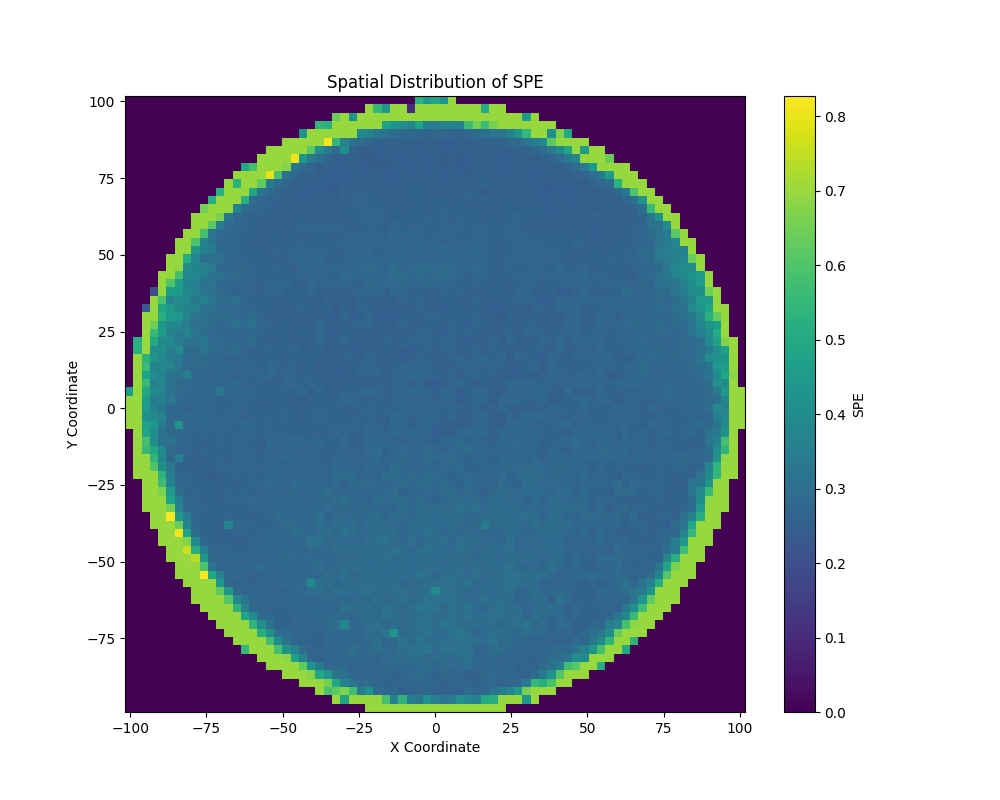

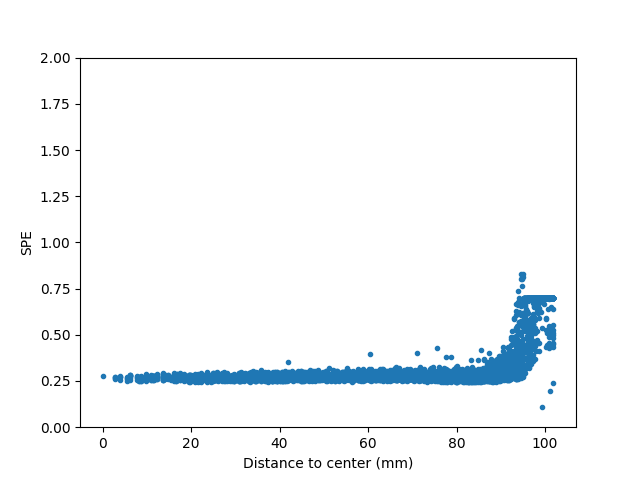

In [139]:
def plot_data_matrix(x, y, data_values, data_label, vmin=None, vmax=None, change_gain =False):
    # Get unique coordinates and sort them
    unique_x = np.unique(x)
    unique_y = np.unique(y)
    
    # Initialize an empty grid
    data_grid = np.zeros((len(unique_y), len(unique_x)))
    
    # Populate the grid
    for i, ux in enumerate(unique_x):
        for j, uy in enumerate(unique_y):
            # Find the index matching the grid position
            idx = np.intersect1d(np.where(x == ux), np.where(y == uy))
            if change_gain == True:
                r = np.sqrt(ux**2+uy**2)
                if r > 95 :
                    try:
                        if data_values[idx[0]]>= 0.70:
                            data_values[idx[0]] = 0.70
                    except:
                        continue
                new_DEGG_dict['SPE_new'] = data_values

            if idx.size > 0:
                data_grid[j, i] = data_values[idx[0]] #<- average, weight


    
    # Transpose the grid for correct orientation, if necessary
    #data_grid = data_grid.T    
    
    #print(data_grid)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    im = plt.imshow(data_grid, extent=(unique_x.min(), unique_x.max(), unique_y.min(), unique_y.max()),  interpolation='nearest',origin='lower', cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label=data_label)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Spatial Distribution of {data_label}')
def plot_data_r(x, y, data_values, data_label, vmin=None, vmax=None):
    print(np.sqrt(max(x)**2+max(y)**2))
    r = np.sqrt(x**2 + y**2)
    mask = r <= 106
        
    
    # Plotting
    #plt.figure(figsize=(10, 8))
    im = plt.plot(r[mask], data_values[mask],'.',c='tab:blue',zorder=1)
    plt.xlabel('Distance to center (mm)')
    plt.ylabel(data_label)
    plt.ylim(vmin,vmax)
    
print((new_DEGG_dict['SPEresolution']))
plot_data_matrix(x,y,new_DEGG_dict['SPEresolution'], "SPE", change_gain= True)

#plot_data_matrix(x,y,new_DEGG_dict['Gain_PE_new'], "Gain", change_gain= False)
plt.figure()
plot_data_r(x,y,new_DEGG_dict['SPE_new'], "SPE")
plt.ylim(0,2)

In [140]:
import os
measurementpath = '/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original'
if not os.path.exists(measurementpath):
    os.mkdir(measurementpath)
   
# Loop through the items in the data dictionary
for data_key, data_values in new_DEGG_dict.items():
    # Set the file path
    file_path = os.path.join(measurementpath, f"{data_key}_459.dat")
    
    # Write data to file
    with open(file_path, 'w') as file:
        for xi, yi, vl in zip(x, y, data_values):
            file.write(f"{round(xi,2)}\t{round(yi,2)}\t{vl}\n")

print("Data files are successfully saved.")

Data files are successfully saved.


/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/Gain_PE_459.dat


/var/folders/fv/0pxk5tys7hq8m0f3pn_hf0z00000gn/T/ipykernel_66432/821304238.py:42: RuntimeWarning: divide by zero encountered in divide
  factor = Rs/R


(207, 207)
/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/SPEresolution_459.dat
(207, 207)
/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/TransitTime_459.dat
(207, 207)
/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/Gain_PE_new_459.dat
(207, 207)
/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/SPE_new_459.dat
/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/SPE_new_459.dat 'SPE'
/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/O

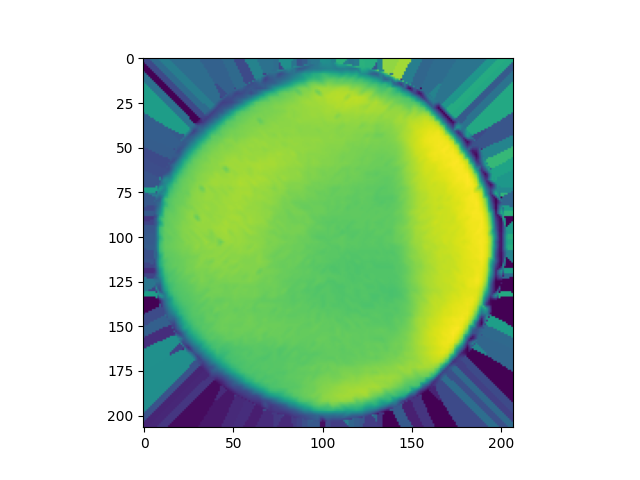

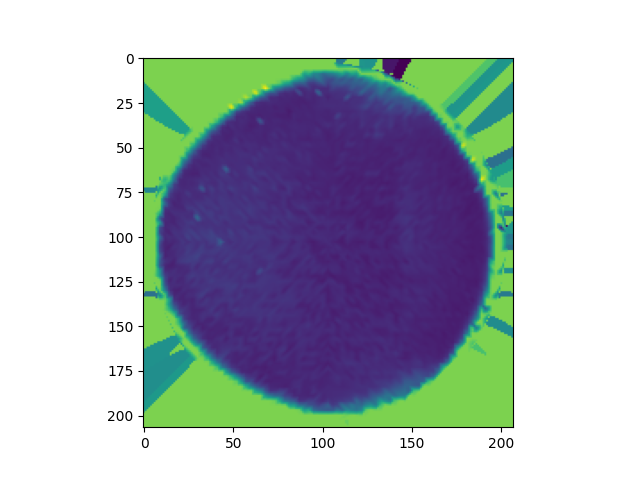

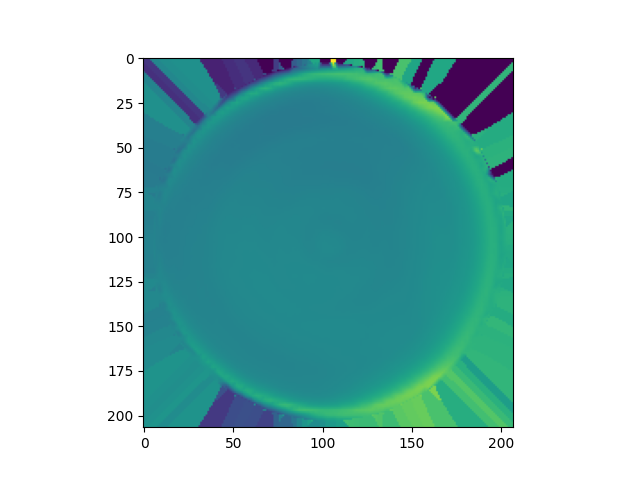

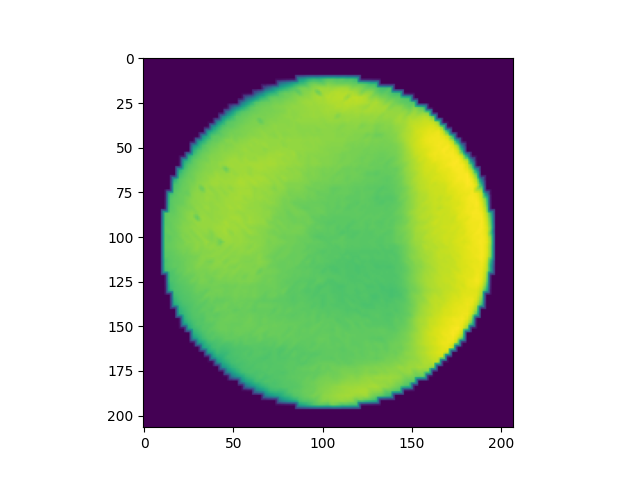

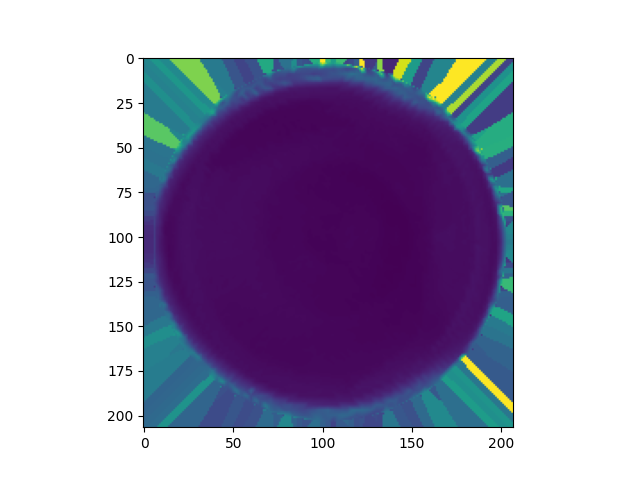

In [143]:
from scipy.interpolate import LinearNDInterpolator
import scipy.interpolate
import glob
class LinearNDInterpolatorExt(object):
    def __init__(self, points,values):
        self.funcinterp=scipy.interpolate.LinearNDInterpolator(points,values)
        self.funcnearest=scipy.interpolate.NearestNDInterpolator(points,values)
    def __call__(self,*args):
        t=self.funcinterp(*args)
        if not np.isnan(t):
            return t.item(0)
        else:
            return self.funcnearest(*args)

bounds = {
    "SPEresolution" : {"posdef" : True, "min" : 0.2, "max" : 1.5},
    "Gain" : {"posdef" : True, "min" : 0.19, "max" : 1.17},
    "TransitTimeSpread" : {"posdef" : True, "min" : 0.5 , "max" :5.0},
    "TransitTime" : {"posdef" : False, "min": -6 , "max" :7}
}

def CheckValue(key, val):
    if bounds[key]["posdef"]:
        val = abs(val)
    if val < bounds[key]["min"]:
        val = bounds[key]["min"]
    if val > bounds[key]["max"]:
        val = bounds[key]["max"]
    return val
    
def scaleXY(polynome, fname):
    x, y, vals = np.loadtxt(f"/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/{fname}", unpack=1)
    
    R = np.sqrt(x**2+y**2)
    mask = R <= 103
    
    x = x[mask]
    y = y[mask]
    vals = vals[mask]
    R = R[mask]
    Rs = polynome(R)
    factor = Rs/R
    
    for i, f in enumerate(factor):
        if f==0. or np.isnan(f) or np.isinf(f):
            factor[i] = 1.
    
    key = fname.split("_")[0]

    x *= factor
    y *= factor
    for i,val in enumerate(vals):
        vals[i] = CheckValue(key, val)
    finterp = LinearNDInterpolatorExt((x,y), vals)
    step = 1
    
    # here put a number a bit larger than the maximal R possible in the simulation, for example mDOM PMT jEllipseXYaxis =37.8704
    xx = np.arange(-103, 103+step, step) 
    vals_interpolated = []
    xinterp = []
    yinterp = []
    rs = []
    matrix = np.zeros((xx.size,xx.size))
    for i,xi in enumerate(xx):
        for j,yi in enumerate(xx):
            svl = finterp(xi, yi)
            vals_interpolated.append(svl)
            matrix[i][j]= svl
            rs.append(np.sqrt(xi**2+yi**2))
            xinterp.append(xi)
            yinterp.append(yi)
            
    vals_interpolated = np.array(vals_interpolated)
    xinterp = np.array(xinterp)
    yinterp = np.array(yinterp)
    plt.figure()
    plt.imshow(matrix)
    print(np.shape(matrix))
    with open(f"/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/{fname}", "w") as file:
        for xi, yi, vali in zip(xinterp, yinterp, vals_interpolated):
            vl = CheckValue(key, vali)
            file.write(f"{round(xi,2)}\t{round(yi,2)}\t{vl}\n")
            
    return R,factor
for file in glob.glob("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/common/data/PMTs/measurement_matching_data/scans/DEGG/original/*"):
    try:
        print(file)
        R,fctor = scaleXY(p, file.split("/")[-1])
        
    except Exception as err:
        print(file, err)

# Step 5


In [144]:
x1,y1,_,gain,spe_res,transit_time,TTS,_ = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/build/step5_finalfinal.dat", unpack=1)

In [114]:
x2,y2,_,gain2,spe_res2,transit_time2,TTS2,_ = np.loadtxt("/Users/beritschlueter/Documents/Dokumente_MacBook/PhD/Thesis/Geant/degg_pmt_matching/OMSim/build/step5_2.dat", unpack=1)

143.89622997146242
1.09048


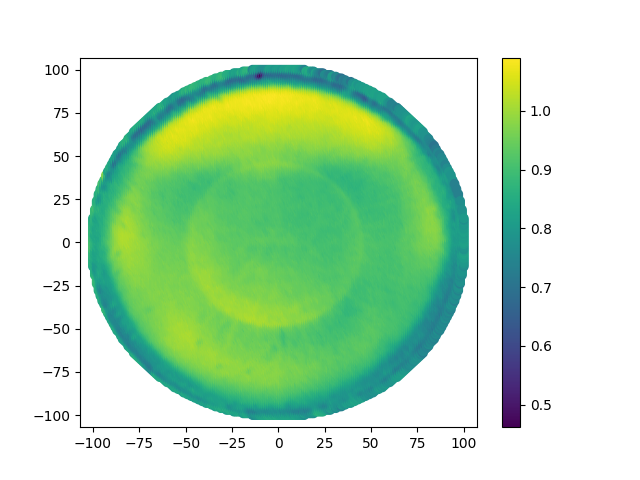

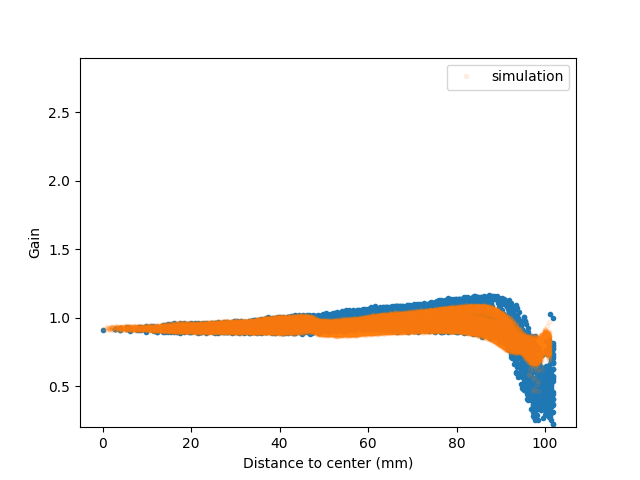

In [145]:
plt.figure()
plt.scatter(x1,y1,c=gain)
plt.ylim(-107,107)
plt.xlim(-107,107)
plt.colorbar()




plt.figure()
r1= np.sqrt(x1**2 + y1**2)
plt.plot(r1 ,gain, marker=".", ls="", c="C1", zorder=2, label="simulation", alpha = 0.1)
#r2= np.sqrt(x2**2 + y2**2)
#plt.plot(r2 ,gain2, marker=".", ls="", c="C2", zorder=2, label="simulation2", alpha = 0.1)

plot_data_r(x,y,new_DEGG_dict['Gain_PE'], "Gain",0.2,2.9 )
plt.legend()


print(max(gain))

143.89622997146242


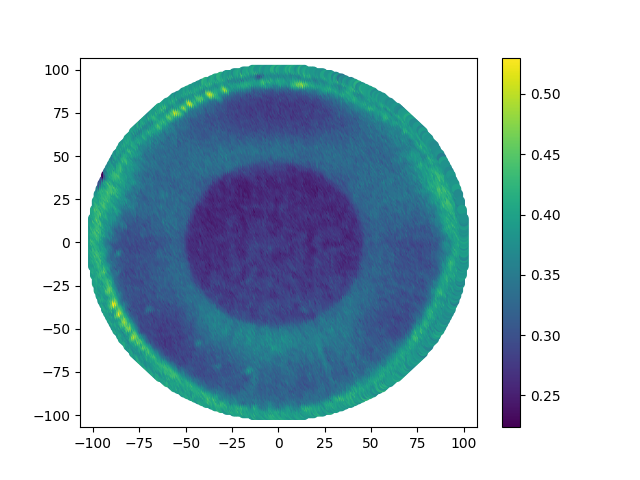

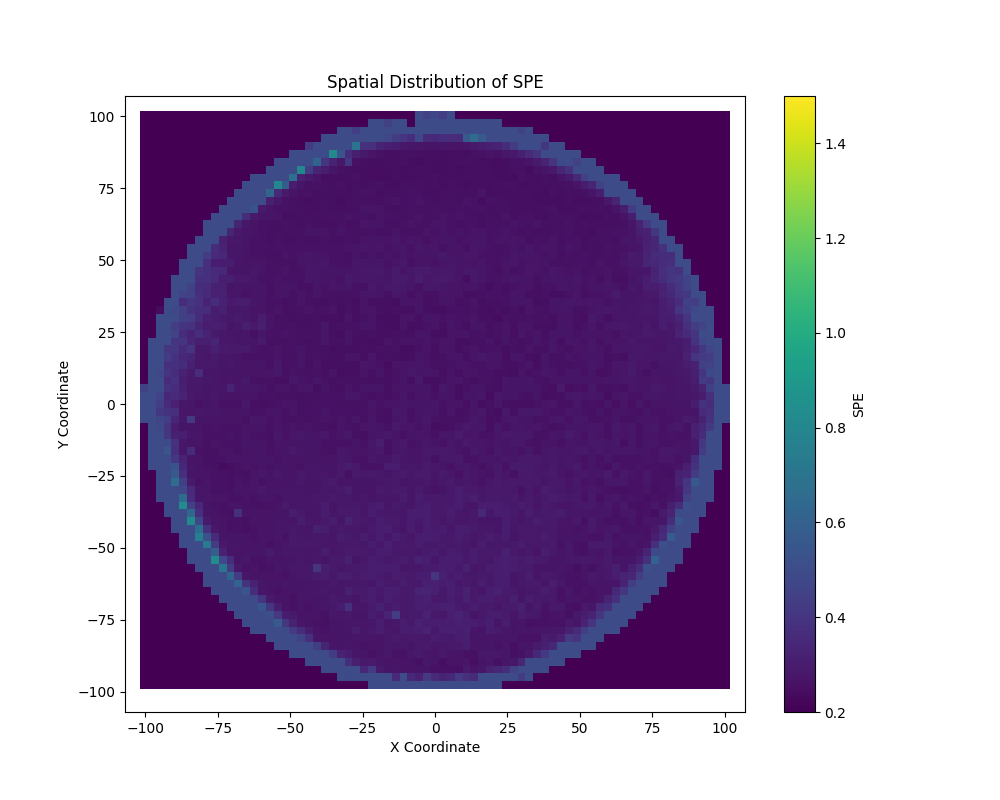

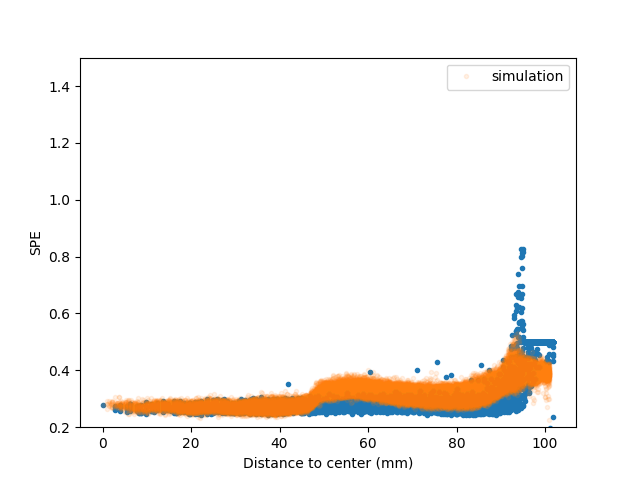

In [116]:
'''SPEresolution" : {"posdef" : True, "min" : 0.2, "max" : 1.5},
    "Gain" : {"posdef" : True, "min" : 0.2, "max" : 1.3},
    "TransitTimeSpread" : {"posdef" : True, "min" : 0.5 , "max" :5.0},
    "TransitTime" : {"posdef" : False, "min": -6 , "max" :7}
}'''

plt.figure()
plt.scatter(x1,y1,c=spe_res)
plt.ylim(-107,107)
plt.xlim(-107,107)
plt.colorbar()


plot_data_matrix(x,y,new_DEGG_dict['SPEresolution'], "SPE",0.2,1.5 )
plt.ylim(-107,107)
plt.xlim(-107,107)

plt.figure()
r1= np.sqrt(x1**2 + y1**2)
plt.plot(r1 ,spe_res, marker=".", ls="", c="C1", zorder=2, label="simulation", alpha = 0.1)

plot_data_r(x,y,new_DEGG_dict['SPEresolution'], "SPE",0.2,1.5 )
plt.legend()


143.89622997146242


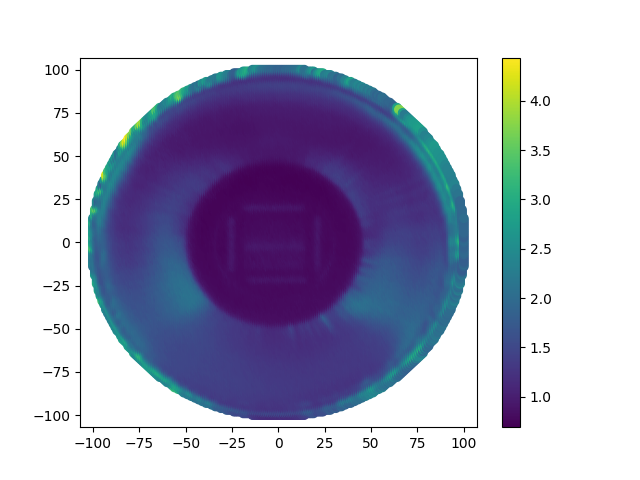

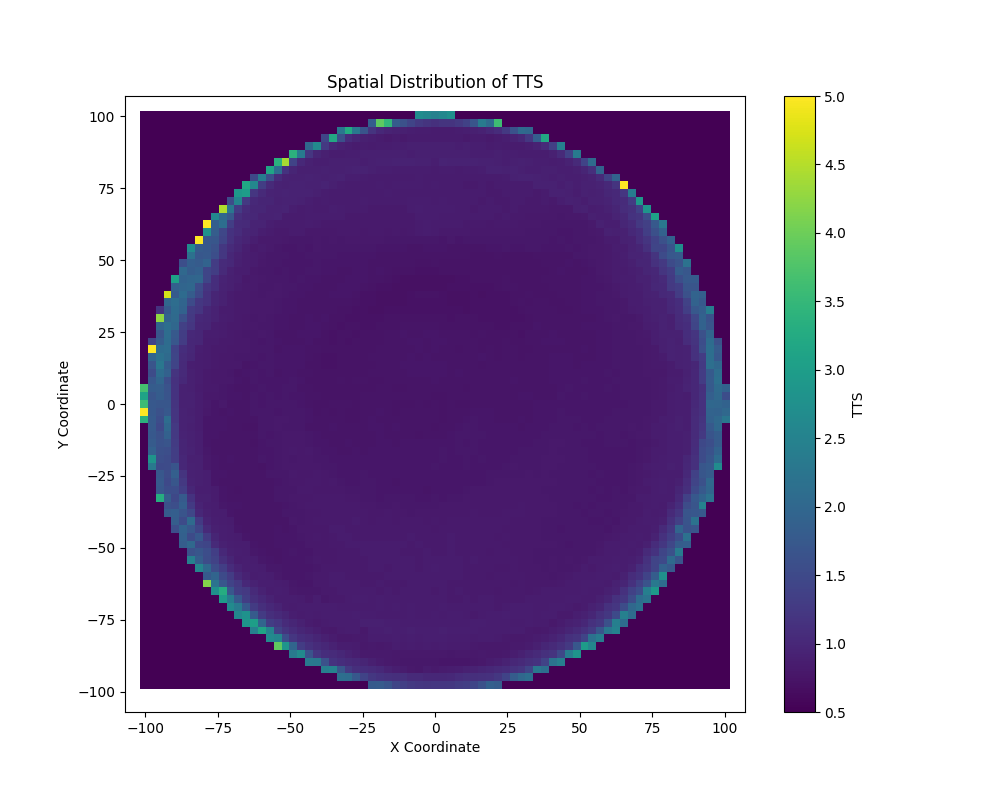

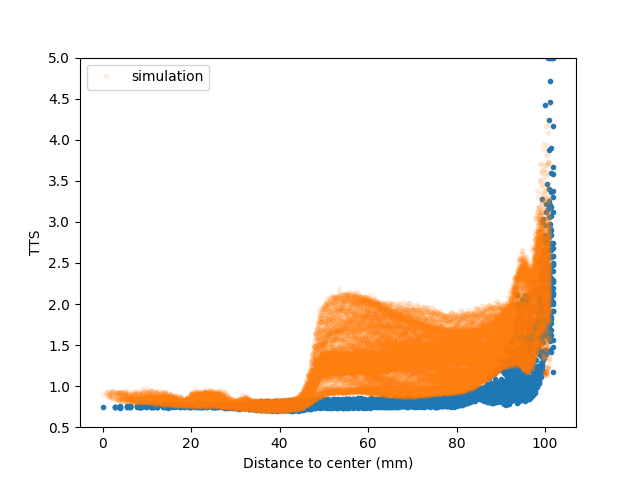

In [147]:
plt.figure()
plt.scatter(x1,y1,c=TTS)
plt.ylim(-107,107)
plt.xlim(-107,107)
plt.colorbar()

plot_data_matrix(x,y,new_DEGG_dict['TransitTimeSpread'], "TTS",0.5,5 )
plt.ylim(-107,107)
plt.xlim(-107,107)


plt.figure()
r1= np.sqrt(x1**2 + y1**2)
plt.plot(r1 ,TTS, marker=".", ls="", c="C1", zorder=2, label="simulation",alpha=0.1)

plot_data_r(x,y,new_DEGG_dict['TransitTimeSpread'], "TTS",0.5,5 )
plt.legend()

143.89622997146242


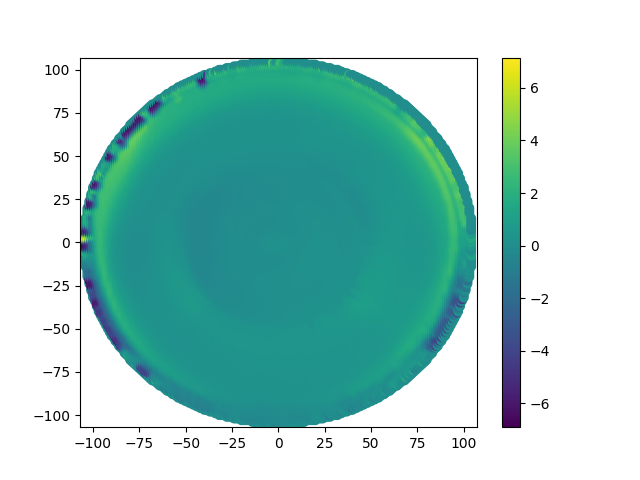

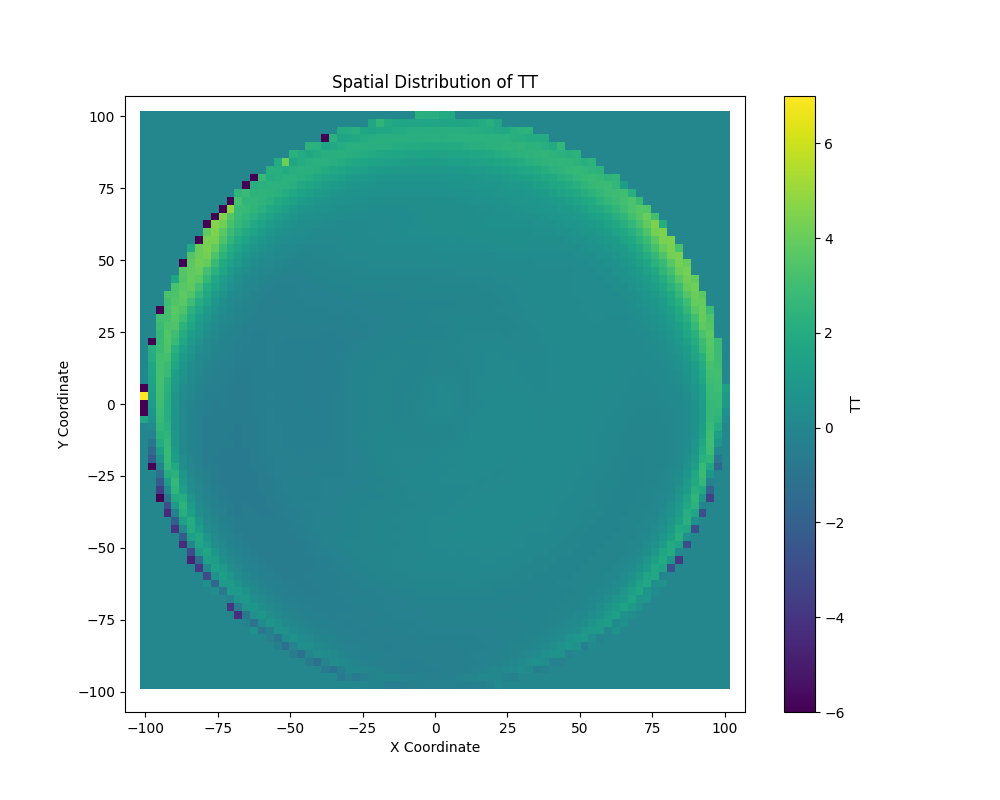

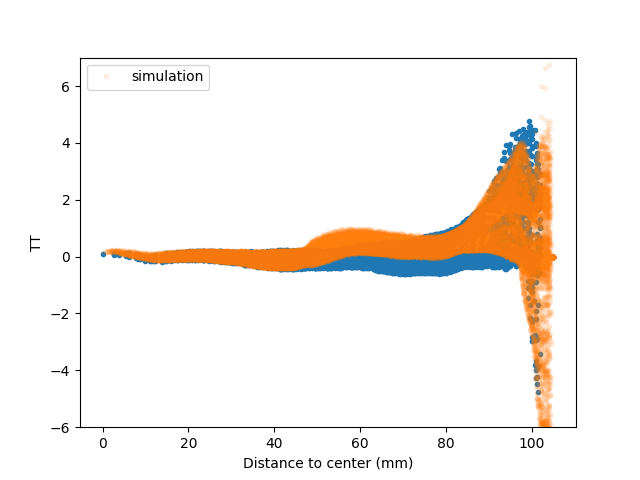

In [17]:
plt.figure()
plt.scatter(x1,y1,c=transit_time)
plt.ylim(-107,107)
plt.xlim(-107,107)
plt.colorbar()

plot_data_matrix(x,y,new_DEGG_dict['TransitTime'], "TT",-6,7 )
plt.ylim(-107,107)
plt.xlim(-107,107)

plt.figure()
r1= np.sqrt(x1**2 + y1**2)
plt.plot(r1 ,transit_time, marker=".", ls="", c="C1", zorder=2, label="simulation",alpha=0.1)

plot_data_r(x,y,new_DEGG_dict['TransitTime'], "TT",-6,7 )
plt.legend()